In [1]:
import numpy as np
from typing import NamedTuple, Tuple
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Arc
plt.style.use('bmh')

In [2]:
class GaussianMixture(NamedTuple):
    """Tuple holding a gaussian mixture"""
    mu: np.ndarray  # (K, d) array - each row corresponds to a gaussian component mean
    var: np.ndarray  # (K, ) array - each row corresponds to the variance of a component
    p: np.ndarray  # (K, ) array = each row corresponds to the weight of a component


def init(X: np.ndarray, K: int,
         seed: int = 0) -> Tuple[GaussianMixture, np.ndarray]:
    """Initializes the mixture model with random points as initial
    means and uniform assingments

    Args:
        X: (n, d) array holding the data
        K: number of components
        seed: random seed

    Returns:
        mixture: the initialized gaussian mixture
        post: (n, K) array holding the soft counts
            for all components for all examples

    """
    np.random.seed(seed)
    n, _ = X.shape
    p = np.ones(K) / K

    # select K random points as initial means
    mu = X[np.random.choice(n, K, replace=False)]
    var = np.zeros(K)
    # Compute variance
    for j in range(K):
        var[j] = ((X - mu[j])**2).mean()

    mixture = GaussianMixture(mu, var, p)
    post = np.ones((n, K)) / K

    return mixture, post

def logsumexp(ns):
    mx = np.max(ns)
    ds = ns - mx
    sumOfExp = np.exp(ds).sum()
    return mx + np.log(sumOfExp)

In [3]:
def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to each of the Gaussian distributions

    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment

    """
    n, _ = X.shape
    K, _ = mixture.mu.shape
    post = np.zeros((n, K))

    ll = 0
    for i in range(n):
        mask = (X[i, :] != 0)
        for j in range(K):
            log_likelihood = log_gaussian(X[i, mask], mixture.mu[j, mask],
                                          mixture.var[j])
            post[i, j] = np.log(mixture.p[j] + 1e-16) + log_likelihood
        total = logsumexp(post[i, :])
        post[i, :] = post[i, :] - total
        ll += total

    return np.exp(post), ll


def log_gaussian(x: np.ndarray, mean: np.ndarray, var: float) -> float:
    """Computes the log probablity of vector x under a normal distribution

    Args:
        x: (d, ) array holding the vector's coordinates
        mean: (d, ) mean of the gaussian
        var: variance of the gaussian

    Returns:
        float: the log probability
    """
    d = len(x)
    log_prob = -d / 2.0 * np.log(2 * np.pi * var)
    log_prob -= 0.5 * ((x - mean)**2).sum() / var
    return log_prob



def mstep(X: np.ndarray, post: np.ndarray, mixture: GaussianMixture,
          min_variance: float = .25) -> GaussianMixture:
    """M-step: Updates the Gaussian statistics (p,mu,var) for better fit
    of the weighted dataset

    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        post: (n, K) array holding the soft counts
            for all components for all examples
        mixture: the current gaussian mixture
        min_variance: the minimum variance for each gaussian

    Returns:
        GaussianMixture: the new gaussian mixture
    """
    n, d = X.shape
    _, K = post.shape

    n_hat = post.sum(axis=0)
    p = n_hat / n

    mu = mixture.mu.copy()
    var = np.zeros(K)

    for j in range(K):
        sse, weight = 0, 0
        for l in range(d):
            mask = (X[:, l] != 0)
            n_sum = post[mask, j].sum()
            if (n_sum >= 1):
                # Updating mean
                mu[j, l] = (X[mask, l] @ post[mask, j]) / n_sum
            # Computing variance
            sse += ((mu[j, l] - X[mask, l])**2) @ post[mask, j]
            weight += n_sum
        var[j] = sse / weight
        if var[j] < min_variance:
            var[j] = min_variance

    return GaussianMixture(mu, var, p)

In [4]:
''' The main algorithm to estimate the parameters/statistics of the Gaussians'''
def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the main algorithm. Iteratively perform E-step 
                                and M-step until convergence

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """

    prev_ll = None
    ll = None
    
    while (prev_ll is None or ll - prev_ll > 1e-6 * np.abs(ll)):
        ''' This algorithm will iteratively run until convergence 
            The convergence is measured by relative improvement in the 
            log-likelihood measure of the Gaussians
        '''
        prev_ll = ll 
        post, ll = estep(X, mixture) # Perform E-step
        mixture = mstep(X, post, mixture) # Perform M-step

    return mixture, post, ll

#### Predicting the incomplete entries from the calculated Statistics:

Let $G_i$ be the $\mathrm{i^{th}-Gaussian}$ distribution, for $1 \leq i \leq K$. Then prediction for the $n^{th}$ missing element is: 

$$ pred_n = \sum_{i=1}^{K} \mathbb{P}(X_n \in G_i) \times Mean(G_i)$$


where $\mathbb{P}(X_n \in G_i)$ is probability that $X_n$ was sampled from $G_i$, and $Mean(G_i)$ is the mean of the $\mathrm{i^{th}-Gaussian}$. 

Below code implements this formula to fill each of the missing matrix entries:

In [5]:
def fill_matrix(X: np.ndarray, mixture: GaussianMixture) -> np.ndarray:
    """Fills an incomplete matrix according to 
    previously estimated Gaussian mixture statistics 

    Args:
        X: (n, d) array of incomplete data (incomplete entries =0)
        mixture: a mixture of gaussians

    Returns
        np.ndarray: a (n, d) array with completed data
    """
    n, d = X.shape
    X_pred = X.copy()
    K, _ = mixture.mu.shape

    for i in range(n):
        mask = X[i, :] != 0
        mask0 = X[i, :] == 0
        post = np.zeros(K)
        for j in range(K):
            log_likelihood = log_gaussian(X[i, mask], mixture.mu[j, mask],
                                          mixture.var[j])
            post[j] = np.log(mixture.p[j]) + log_likelihood
        post = np.exp(post - logsumexp(post))
        X_pred[i, mask0] = np.dot(post, mixture.mu[:, mask0])
    return X_pred

In [6]:
def plot(X: np.ndarray, mixture: GaussianMixture, post: np.ndarray,
         title: str):
    """Plots the Gaussians and the data points for 2D data"""
    _, K = post.shape

    percent = post / post.sum(axis=1).reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.title.set_text(title)
    ax.set_xlim((-20, 20))
    ax.set_ylim((-20, 20))
    r = 0.75
    color = ["r", "b", "k", "y", "m", "c"]
    for i, point in enumerate(X):
        theta = 0
        for j in range(K):
            offset = percent[i, j] * 360
            arc = Arc(point,
                      r,
                      r,
                      0,
                      theta,
                      theta + offset,
                      edgecolor=color[j])
            ax.add_patch(arc)
            theta += offset
    for j in range(K):
        mu = mixture.mu[j]
        sigma = np.sqrt(mixture.var[j])
        circle = Circle(mu, sigma, color=color[j], fill=False)
        ax.add_patch(circle)
        legend = "mu = ({:0.2f}, {:0.2f})\n stdv = {:0.2f}".format(
            mu[0], mu[1], sigma)
        ax.text(mu[0], mu[1], legend)
    plt.axis('equal')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.show()

In [7]:
def rmse(X, Y):
    ''' Root mean squared error'''
    return np.sqrt(np.mean((X - Y)**2))

In [8]:
def missing(data):
    ''' Measure the percentage of elements 
        missing in the data matrix 
    '''
    return 100*(data==0).mean()

def run_test():
    '''
    Estimate the statistics for:
        Experimental dataset 1
    '''
    K = 5 # Number of clusters / classes
    seed = 0 # Setting numpy random seed=0
    mixture, post = init(X, K, seed)
    mixture, post, ll = run(X, mixture, post)
    title = "Plot for Experimental set 1"
    plot(X,mixture,post,title) #PLotting the Gaussians and the data

def run_matrix_completion():
    '''Evaluating the technique on the Netflix data'''
    K = 12
    seed = 1
    mixture, post = init(X, K, seed)
    mixture, post, ll = run(X, mixture, post)
    X_pred = fill_matrix(X, mixture)
    X_gold = np.loadtxt('netflix_complete.txt')
    print("RMSE Error:", rmse(X_gold, X_pred))

def Test():
    ''' Evaluating the technique on 
        Experimental dataset 2 '''
    X = np.loadtxt("test_incomplete.txt")
    X_gold = np.loadtxt("test_complete.txt")
    print("X_incomplete:\n" + str(X)) # Printing the incomplete data matrix
                                      # 0's indicate missing entries
    K = 5 # Number of Gaussians 
    n, d = X.shape
    seed = 0 # Numpy random seed 
    print('Missing %:',np.round(missing(X),6))
    mixture, _ = init(X, K, seed)
    print()
    post, ll = estep(X, mixture)

    mu, var, p = mstep(X, post, mixture)
    (mu, var, p), post, ll = run(X, mixture, post)

    X_pred = fill_matrix(X, GaussianMixture(mu, var, p))
            # Filling the matrix uing the above computed statistics 
        
    error = rmse(X_gold, X_pred) # Evaluating RMSE error
    print("X_complete:\n" + str(X_gold)) # Printing original complete 
                                         #  data matrix 
    print("X_pred:\n" + str(X_pred)) 
    print("RMSE Error: " + str(error)) 


### Loading and testing on Experimental Dataset 1

Experimental dataset 1 can be found in "exp_data5.txt" file. This data set is a set of 2D points (1000 such points) on the cartesian plane, hence can be represented by a 1000 x 2 matrix. It is also to visualize on the 2D cartesian and hence we will use this to demonstrate how the algorithm converges tying to estimate the statistics for the Gaussians.  

This dataset was originally contructed by randomly sampling points from 5 different Gaussian distributions.

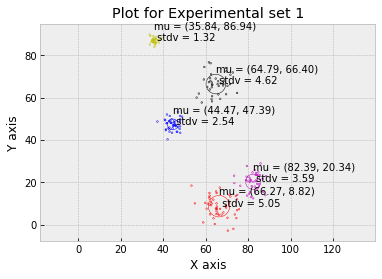

In [9]:
X = np.loadtxt("exp_data5.txt")
run_test()

The circles are the different Gaussian distributions. The centre of the circle is the Mean (mu) and the radius of the circle is equal to the Standard Deviation (stdv) of the corresponding Gaussian distribution. 

All the Gaussians are initialized randomly. 

In [10]:
'''
   Displaying a GIF to demonstrate how the Gaussian statistics 
   iteratively converge to the data points. 
   Obtained by saving the above plot for iterations from 1 to 30
   of the algorithm. 
'''
from IPython.display import HTML
HTML('<img src="result.gif">')

We can see that after each iteration of the algorithm, the Gaussian statistics (the circles) adjust more and more to the data points. After some iterations (30 in the above case) the algorithm converges. 

### Plotting Missing(%) vs Mean Absolute error for Experimental dataset 1

In this experiment we try to obtain a plot between the percentage of missing data, and the error obtained after recovery (in terms of Mean Absolute Error) for this method. We use the Experimental dataset 1 for this purpose. 

$$ \mathrm{Mean Absolute Error} = \frac{\sum_{i}^{N} \mid X_i - Y_i \mid }{N} $$ 

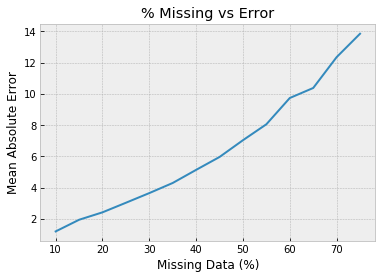

In [11]:
np.random.seed(0) # Setting random seed 
sp = []
mae = []
for spar in [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75]:
    data = np.loadtxt("exp_data5.txt") # Loading the data
    X_gold = np.array(data) # The original complete data

    num = 2*len(data)*spar # Number of missing elements 

    while num>0: # Randomly selecting 'num' elements and setting them 0
        i = np.random.randint(0,data.shape[0])
        j = np.random.randint(0,data.shape[1])
        if data[i][j] > 0:
            data[i][j] = 0
            num-=1

    X= np.array(data) # The incomplete data

    K = 5 # Number of Gaussians 
    seed = 0
    mixture, post = init(X, K, seed) #Initializing the statistics
    mixture, post, ll = run(X, mixture, post) # Estimating the statistics
    X_pred = fill_matrix(X, mixture) # Filling the incomplete matrix 
                                     # using the above calculated stats
    sp.append(100*spar)
    mae.append(np.mean(np.abs(X_pred-X_gold)))
    
plt.plot(sp,mae)
plt.title('% Missing vs Error')
plt.xlabel('Missing Data (%)')
plt.ylabel('Mean Absolute Error')
plt.show()

As expected, more the missing data, greater the recovery error. 

### For Experimental data set 2

This data set is a small subset of the Netflix version, to demonstrate the input, output of the algorithm. 
It is a matrix of 20 x 5 dimension. 

X_incomplete: Is the incomplete data with missing entries (0 indicated missing value) 

X_complete: This is the original complete data

X_pred: The prediction matrix after running our algorithm and filling the matrix. 

RMSE Error = $\left( \frac{\sum_{i=1}^{N} (X_i - Y_i)^2 }{N}\right)^{1/2}$

In [12]:
Test()

X_incomplete:
[[2. 5. 3. 0. 0.]
 [3. 5. 0. 4. 3.]
 [2. 0. 3. 3. 1.]
 [4. 0. 4. 5. 2.]
 [3. 4. 0. 0. 4.]
 [1. 0. 4. 5. 5.]
 [2. 5. 0. 0. 1.]
 [3. 0. 5. 4. 3.]
 [0. 5. 3. 3. 3.]
 [2. 0. 0. 3. 3.]
 [3. 4. 3. 3. 3.]
 [1. 5. 3. 0. 1.]
 [4. 5. 3. 4. 3.]
 [1. 4. 0. 5. 2.]
 [1. 5. 3. 3. 5.]
 [3. 5. 3. 4. 3.]
 [3. 0. 0. 4. 2.]
 [3. 5. 3. 5. 1.]
 [2. 4. 5. 5. 0.]
 [2. 5. 4. 4. 2.]]
Missing %: 19.0

X_complete:
[[2. 5. 3. 4. 3.]
 [3. 5. 3. 4. 3.]
 [2. 4. 3. 3. 1.]
 [4. 4. 4. 5. 2.]
 [3. 4. 4. 4. 4.]
 [1. 5. 4. 5. 5.]
 [2. 5. 4. 5. 1.]
 [3. 4. 5. 4. 3.]
 [3. 5. 3. 3. 3.]
 [2. 5. 3. 3. 3.]
 [3. 4. 3. 3. 3.]
 [1. 5. 3. 5. 1.]
 [4. 5. 3. 4. 3.]
 [1. 4. 3. 5. 2.]
 [1. 5. 3. 3. 5.]
 [3. 5. 3. 4. 3.]
 [3. 5. 4. 4. 2.]
 [3. 5. 3. 5. 1.]
 [2. 4. 5. 5. 3.]
 [2. 5. 4. 4. 2.]]
X_pred:
[[2.         5.         3.         3.94430072 1.5291021 ]
 [3.         5.         3.11560886 4.         3.        ]
 [2.         4.99001402 3.         3.         1.        ]
 [4.         4.21254903 4.         5.         2.     

### Testing on the NetFlix dataset 
The dataset provides movie rating for 1200 different movies by 1200 different Netflix users. 
Hence it is a 1200 x 1200 matrix. (This is a subset of the orignal Netflix Prize challenge 2009 which has rating information for millions of users on thousands of movies)

The "netflix_incomplete.txt" dataset is the incomplete version of the this dataset (with around 23% missing entries). And "netflix_complete.txt" is the complete version to be used for measuring the error. 

RMSE Error = $\left( \frac{\sum_{i=1}^{N} (X_i - Y_i)^2 }{N}\right)^{1/2}$

In [13]:
X = np.loadtxt("netflix_incomplete.txt")
print('Missing %:',np.round(missing(X),6))
run_matrix_completion()   # Takes about 1-2 mins to run

Missing %: 22.793889
RMSE Error: 0.4804908505400682
